/tmp/ipykernel_3340483/3085450978.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(chkpt_path, map_location="cpu"))


  0%|          | 0/100 [00:00<?, ?it/s]

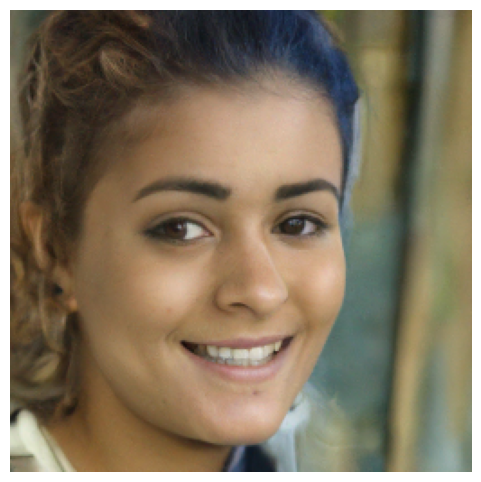

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import make_grid
import sys
sys.path.append("/home/armand/PhD/oc-guidance/models")
sys.path.append("/home/armand/PhD/oc-guidance/")
from guided_diffusion import create_model, create_model_and_diffusion, model_and_diffusion_defaults
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ffhq_config = model_and_diffusion_defaults()

ffhq_config.update({
    "num_channels": 128,
    "num_heads": 4,
    "num_res_blocks": 1,
    "attention_resolutions": "16",
    "dropout": 0.0,
    "learn_sigma": True,
    "use_scale_shift_norm": True,
    "use_fp16": False,
    "resblock_updown": True,
    "num_heads_upsample": -1,
    "num_head_channels": 64,
    "image_size": 256,
    "class_cond": False,
    "diffusion_steps": 100,
    "rescale_timesteps": True,
    "use_new_attention_order": False,
})

# --- Load model and diffusion ---
model, diffusion = create_model_and_diffusion(**ffhq_config)
chkpt_path = "/home/armand/PhD/FFF_fiberlearning/notebooks/GenerativeModels/ffhq_10m.pt"
model.load_state_dict(torch.load(chkpt_path, map_location="cpu"))
model.to(device)
model.eval()

# --- Sampling ---
def sample(model, diffusion, batch_size=1):
    # Unconditional sampling (no classifier guidance)
    shape = (batch_size, 3, ffhq_config["image_size"], ffhq_config["image_size"])
    sample = diffusion.p_sample_loop(
        model,
        shape,
        clip_denoised=True,
        progress=True,
        device=device,
    )
    return sample

# --- Plotting ---
def show_images(tensor):
    # Rescale from [-1, 1] to [0, 1]
    imgs = (tensor + 1) * 0.5
    imgs = imgs.clamp(0, 1)
    grid = make_grid(imgs, nrow=1)
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(6,6))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# --- Run sampling ---
with torch.no_grad():
    images = sample(model, diffusion, batch_size=1)

show_images(images)


In [1]:
import torch
from tqdm import tqdm

def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.

    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)

@torch.no_grad()
def ddim_sample(
    model,
    diffusion,
    shape,
    eta=0.0,
    timesteps=50,
):
    device = next(model.parameters()).device
    bs = shape[0]
    xt = torch.randn(shape, device=device)

    # Create the timesteps and precompute step indices
    full_steps = diffusion.num_timesteps
    ts = torch.linspace(full_steps - 1, 0, timesteps, dtype=torch.long, device=device)
    ss = torch.cat([ts[1:], torch.tensor([0], device=device)])

    xt_s = []
    x0_s = []
    alphas_cumprod = torch.tensor(diffusion.alphas_cumprod, device=device, dtype=torch.float32)
    
    for i, (ti, si) in enumerate(tqdm(zip(ts, ss), total=timesteps)):
        t = torch.full((bs,), ti.item(), dtype=torch.long, device=device)
        s = torch.full((bs,), si.item(), dtype=torch.long, device=device)
    

        # DDIM coefficients
        sigma = (
            eta
            * torch.sqrt((1 - alpha_bar_prev) / (1 - alpha_bar))
            * torch.sqrt(1 - alpha_bar / alpha_bar_prev)
        )    
        # Predict noise and log-variance
        #model_out = model(xt, t)
        #eps, logvar = torch.chunk(model_out, 2, dim=1)
        #pred_std = (0.5 * logvar).exp()
        #pred_std = torch.clamp(pred_std, 0, 1.0)
    
        # Predict x0 from noise
        #sqrt_alpha_t = alpha_t.sqrt()
        #sqrt_one_minus_alpha_t = (1 - alpha_t).sqrt()
        #x0_pred = (xt - sqrt_one_minus_alpha_t * eps) / sqrt_alpha_t
        #x0_pred = torch.clamp(x0_pred, -1, 1)
        #x0_pred = diffusion._predict_xstart_from_eps(xt, ti, eps)
        out = diffusion.p_mean_variance(model, xt, t, clip_denoised=True)
        eps = diffusion._predict_eps_from_xstart(xt, t, out["pred_xstart"])
        x0_pred = out["pred_xstart"]
        # DDIM update with learned noise scale
        noise = torch.randn_like(xt)
        mean_pred = (
            out["pred_xstart"] * torch.sqrt(alpha_bar_prev)
            + torch.sqrt(1 - alpha_bar_prev - sigma**2) * eps
        )
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(xt.shape) - 1)))
        )  # no noise when t == 0
        xt = mean_pred + nonzero_mask * sigma * noise
        
        xt_s.append(xt.cpu())
        x0_s.append(x0_pred.cpu())


    return x0_s[-1], xt_s  # final image + optionally full trajectory


In [116]:
samples, traj = ddim_sample(
    model=model,
    diffusion=diffusion,
    shape=(1, 3, 256, 256),
    eta=0.05,           # set > 0 for stochastic DDIM
    timesteps=100
)


100%|█████████████████████████████████████████| 100/100 [00:03<00:00, 25.59it/s]


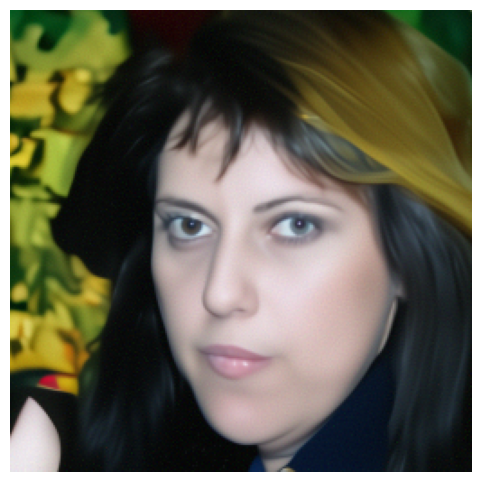

In [117]:
def show_images(tensor):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid

    imgs = (tensor + 1) * 0.5
    imgs = imgs.clamp(0, 1)
    grid = make_grid(imgs, nrow=1)
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(6, 6))
    plt.imshow(npimg)
    plt.axis('off')
    plt.show()

show_images(samples)


In [71]:
import torch
from tqdm import tqdm

@torch.no_grad()
def ancestral_sample(
    model,
    diffusion,
    shape,
    timesteps=None,  # use all diffusion timesteps if None
    use_predicted_variance=True,
):
    device = next(model.parameters()).device
    bs = shape[0]

    # Convert noise schedule to torch tensor
    alphas_cumprod = torch.tensor(diffusion.alphas_cumprod, device=device, dtype=torch.float32)
    betas = torch.tensor(diffusion.betas, device=device, dtype=torch.float32)

    if timesteps is None:
        ts = list(range(diffusion.num_timesteps))
    else:
        assert timesteps <= diffusion.num_timesteps
        ts = list(torch.linspace(diffusion.num_timesteps - 1, 0, timesteps).long())

    x = torch.randn(shape, device=device)
    x_s, x0_s = [], []

    for i, ti in enumerate(tqdm(ts)):
        t = torch.full((bs,), ti, device=device, dtype=torch.long)

        out = diffusion.p_mean_variance(
            model,
            x,
            t,
            clip_denoised=True,
        )
        noise = torch.randn_like(x)
        nonzero_mask = (
            (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        )  # no noise when t == 0
        x = out["mean"] + nonzero_mask * torch.exp(0.5 * out["log_variance"]) * noise
        x_s.append(x)
        x0_s.append(out["pred_xstart"])

    return x0_s[-1], x_s  # final denoised image and trajectory


100%|███████████████████████████████████████| 1000/1000 [00:38<00:00, 26.15it/s]


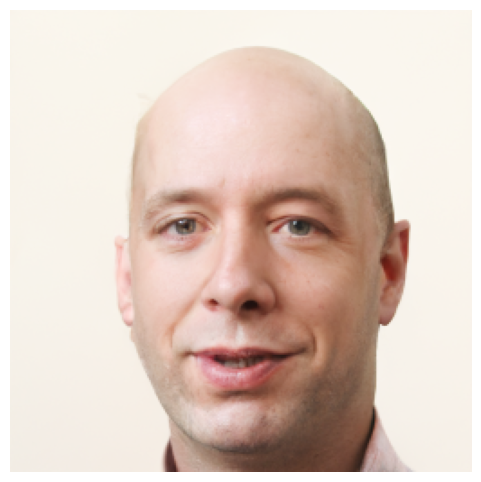

In [74]:
x_final, traj = ancestral_sample(
    model=model,
    diffusion=diffusion,
    shape=(1, 3, 256, 256),
    timesteps=1000,                  # can be None for full 1000-step schedule
    use_predicted_variance=True     # False = fixed schedule
)
show_images(traj[-1])
